# Import the moduls that will do all the work

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning and Preparation

In [54]:
df = pd.read_csv('predictive_maintenance.csv', header= 0)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Identify the columns type and the shape of the data

In [14]:
df.dtypes

type                    object
air_temperature        float64
process_temperature    float64
rotational_speed         int64
torque                 float64
tool_wear_min            int64
target                   int64
failure_type            object
dtype: object

In [15]:
df.shape

(10000, 8)

There are some unneeded column like UDI and Product ID that were randomly assigned which we will not use it
for our data

In [55]:
df.drop(['UDI', 'Product ID'], axis= 1, inplace= True)

Rename and changing the column's name to the 'normal' format to make it easier to write

In [56]:
df = df.rename(columns={'Type': 'type', 'Air temperature [K]': 'air_temperature',
                        'Process temperature [K]': 'process_temperature',
                        'Rotational speed [rpm]': 'rotational_speed',
                        'Torque [Nm]': 'torque', 'Tool wear [min]': 'tool_wear_min',
                        'Target': 'target', 'Failure Type': 'failure_type'})

In [57]:
df['failure_type'] = df['failure_type'].str.replace(' ', '_') 
df['failure_type'] = df['failure_type'].str.lower()

Identify missing and duplicated values in the data

In [6]:
df.isna().sum()

type                   0
air_temperature        0
process_temperature    0
rotational_speed       0
torque                 0
tool_wear_min          0
target                 0
failure_type           0
dtype: int64

In [13]:
df.duplicated().sum()

0

there were no missing value and no duplicated values in the data

# Data Manipulation

Identify the count of our target values

In [13]:
df['target'].value_counts()

0    9661
1     339
Name: target, dtype: int64

The target's value '0' represent 'No Failure' and value '1' represent 'Failure'

In [14]:
df['failure_type'].value_counts()

no_failure                  9652
heat_dissipation_failure     112
power_failure                 95
overstrain_failure            78
tool_wear_failure             45
random_failures               18
Name: failure_type, dtype: int64

there are some miss observation in 'no failure' values on target's column and failure type's column, we can see that the count of the values 'no failure' in the target's column is not equal to its count in failure type's column , so we need to find the values that miss imputed to the data 

In [58]:
df_random_failure = df.loc[(df['target'] == 0) & (df['failure_type'] != 'no_failure')]
df_random_failure

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
1221,M,297.0,308.3,1399,46.4,132,0,random_failures
1302,L,298.6,309.8,1505,45.7,144,0,random_failures
1748,H,298.4,307.7,1626,31.1,166,0,random_failures
2072,L,299.6,309.5,1570,35.5,189,0,random_failures
2559,L,299.3,309.0,1447,50.4,140,0,random_failures
3065,M,300.1,309.2,1687,27.7,95,0,random_failures
3452,H,301.6,310.5,1602,32.3,2,0,random_failures
5471,L,302.7,312.3,1346,61.2,170,0,random_failures
5489,L,302.6,312.1,1499,35.0,215,0,random_failures
5495,H,302.9,312.5,1357,55.0,12,0,random_failures


in this case there are 18 rows in failure's type column specifically 'random failure'
that have a value '0' in target's columns,  we know that the values '0' indicates No Failure,
so we need to replace the value to '1' that represent Failures

In [59]:
df.loc[df['failure_type'] == 'random_failures', 'target'] = 1
df['target'].value_counts()

0    9643
1     357
Name: target, dtype: int64

In [10]:
df['failure_type'].value_counts()

no_failure                  9652
heat_dissipation_failure     112
power_failure                 95
overstrain_failure            78
tool_wear_failure             45
random_failures               18
Name: failure_type, dtype: int64

yet still have some miss observation where the '0' values in target's column is still not equal
to total values of 'no failure' in failure type's column.

In [60]:
df_failure_type_error = df[(df['target'] != 0) & (df['failure_type'] == 'no_failure')]
df_failure_type_error

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
1437,H,298.8,309.9,1439,45.2,40,1,no_failure
2749,M,299.7,309.2,1685,28.9,179,1,no_failure
4044,M,301.9,310.9,1419,47.7,20,1,no_failure
4684,M,303.6,311.8,1421,44.8,101,1,no_failure
5536,M,302.3,311.8,1363,54.0,119,1,no_failure
5941,L,300.6,310.7,1438,48.5,78,1,no_failure
6478,L,300.5,309.8,1663,29.1,145,1,no_failure
8506,L,298.4,309.6,1710,27.3,163,1,no_failure
9015,L,297.2,308.1,1431,49.7,210,1,no_failure


in this case there are 9 rows in failure's type column specifically 'no failure'
that have a value '1' in target's columns,  we also know that '1' indicates 'Failure',
so we need to replace the target's value to '0' that represent No Failures

In [61]:
df_failure_type_error.loc[:, 'target'] = 0
df.update(df_failure_type_error)
df['target'] = df['target'].astype('int')
df.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
0,M,298.1,308.6,1551.0,42.8,0.0,0,no_failure
1,L,298.2,308.7,1408.0,46.3,3.0,0,no_failure
2,L,298.1,308.5,1498.0,49.4,5.0,0,no_failure
3,L,298.2,308.6,1433.0,39.5,7.0,0,no_failure
4,L,298.2,308.7,1408.0,40.0,9.0,0,no_failure


In [18]:
df['target'].value_counts()

0    9652
1     348
Name: target, dtype: int64

In [19]:
df['failure_type'].value_counts()

no_failure                  9652
heat_dissipation_failure     112
power_failure                 95
overstrain_failure            78
tool_wear_failure             45
random_failures               18
Name: failure_type, dtype: int64

Now our data is ready to be explored

# Ekploratory Data Analysis

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
process_temperature,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
tool_wear_min,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
target,10000.0,0.03480,0.183282,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Correlation of each features')

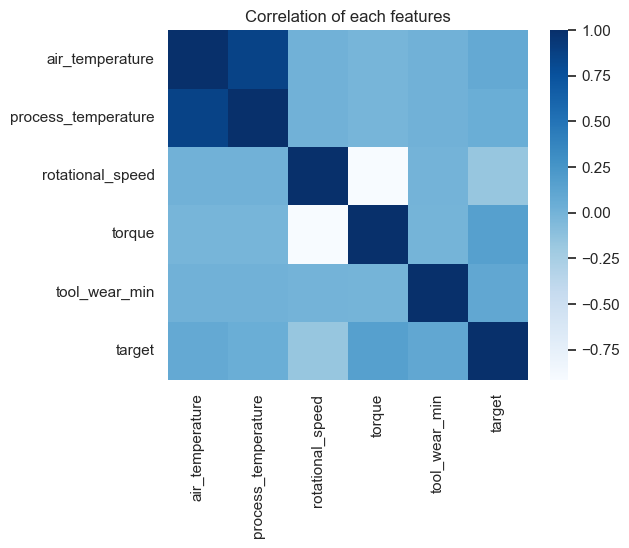

In [52]:
corr_df = df.corr(method='spearman')
fig = plt.figure(figsize=(9,7), dpi= 100)
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.heatmap(corr_df, cmap='Blues')
ax.set_title('Correlation of each features')

from the heat map we can see that air temperature and process temperature were highly correlated each other. in other word, while the value of air temperature increase, also increase the value of process temperature. it inversely proportional with the correlation of torque and rotational speed, in this case while the value of torque increased, the value of rotational speed decrease. 

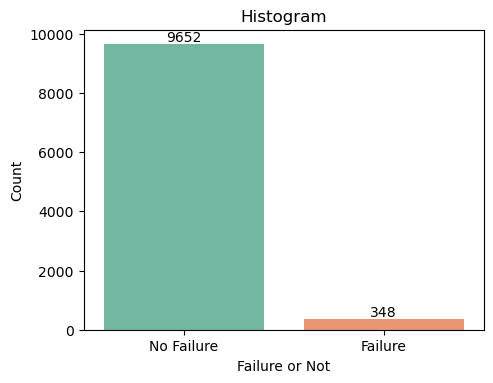

In [27]:
fig = plt.figure(figsize=(8,6), dpi= 100)
#ax = sns.set_theme(style="whitegrid")
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data=df, x='target', palette="Set2")

for c in ax.containers:
    ax.bar_label(c)

ax.set_title('Histogram')
ax.set_xlabel('Failure or Not')
ax.set_ylabel('Count')
ax.set_xticklabels(['No Failure', 'Failure'])
plt.show()

the data showed about 96.5 % of the target variabel were '0' or represent No Failures and only
about 3.5 % of the target variabel were '1' or represent Failures. It means that the data were 
highly imbalanced and we need to to some treatment to make each target's feature were equal

In [28]:
df_failure= df[df['failure_type'] != "no_failure"]
failure_sorted = df_failure.groupby('failure_type')['target'].count().sort_values(ascending=False)
failure_sorted

failure_type
heat_dissipation_failure    112
power_failure                95
overstrain_failure           78
tool_wear_failure            45
random_failures              18
Name: target, dtype: int64

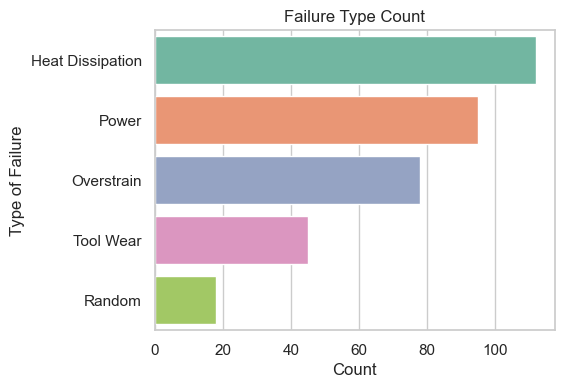

In [29]:
fig = plt.figure(figsize=(8,6), dpi= 100)
ax = sns.set_theme(style="whitegrid")
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data= df.query('failure_type != "no_failure"'), y='failure_type',
                   palette="Set2", order=['heat_dissipation_failure', 'power_failure',
                                         'overstrain_failure', 'tool_wear_failure',
                                         'random_failures'])

ax.set_title('Failure Type Count')
ax.set_xlabel('Count')
ax.set_ylabel('Type of Failure')
ax.set_yticklabels(['Heat Dissipation','Power','Overstrain','Tool Wear','Random'], rotation= 0)
plt.show()

the most frequent failure's that occurs in the machine product sequentially are Heat Dissipation Failure, Power Failure
Overstrain Failure, Total Wear Failure and Random failure

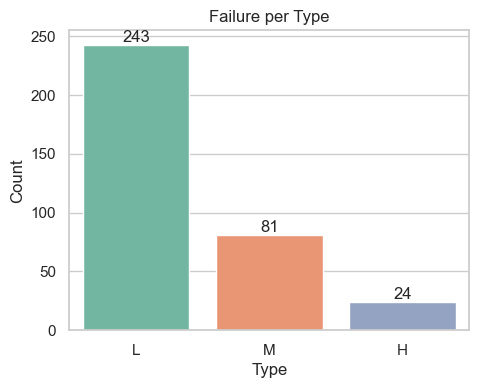

In [14]:
fig = plt.figure(figsize=(8,6), dpi= 100)
ax = sns.set_theme(style="whitegrid")
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data= df.query("target == 1"), x='type', palette="Set2",
                   order=['L', 'M', 'H'])

for c in ax.containers:
    ax.bar_label(c)
    
ax.set_title('Failure per Type')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
plt.show()


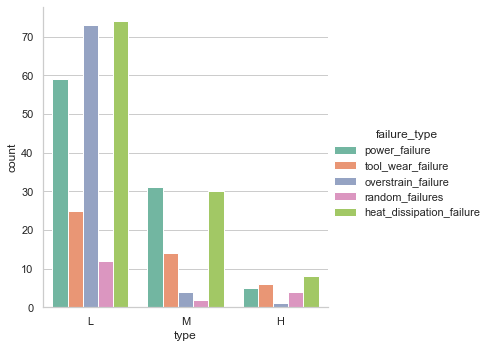

In [15]:
ax = sns.set_theme(style="whitegrid")
ax = sns.catplot(data= df.query("target == 1"), x='type', palette="Set2", hue='failure_type', kind='count',
                   order=['L', 'M', 'H'])
plt.show()

as the graph above we can see that the machine with type 'L' or stands for 'Low Quality' tends to be Failured compared
to machine with type 'H' or stands for 'High Quality'.  

In [67]:
df.groupby('type')['target'].count()

type
H    1003
L    6000
M    2997
Name: target, dtype: int64

the problem is the product with type L or 'Low' are consist about 60 % of all product,
as we can see product with type H or 'High' are only about 10 % of the product, hence we cannot
conclude that product with type H are much better than product with type L in term of Failures,
so we need to see the ratio of total failure on each type  

In [13]:
df_failured = df.query('failure_type != "no_failure"')

In [14]:
count_type_L = len(df[df['type'] == 'L'])
count_failure__L = len(df_failured[df_failured['type'] == 'L'])
print('Type L Failure Ratio: {:.2f} %'.format(count_failure__L / count_type_L * 100))

count_type_M = len(df[df['type'] == 'M'])
count_failure__M = len(df_failured[df_failured['type'] == 'M'])
print('Type M Failure Ratio: {:.2f} %'.format(count_failure__M / count_type_M * 100))

count_type_H = len(df[df['type'] == 'H'])
count_failure__H = len(df_failured[df_failured['type'] == 'H'])
print('Type H Failure Ratio: {:.2f} %'.format(count_failure__H / count_type_H * 100))

Type L Failure Ratio: 4.05 %
Type M Failure Ratio: 2.70 %
Type H Failure Ratio: 2.39 %


as we can see that the product from type L are tend to be failured if we compared it with another product, but
we can directly conclude that because as we know that the data are imbalanced and the quantity of the type L
product are much more higher than others. 

in this box the labels are refers to: NF = No Failure, PF = Power Failure, TWF= Tool Wear Failure, OVF= Overstrain Failure, RF=Random Failure, and HDF= Heat Dissipation Failure

Text(0, 0.5, 'Air Tempetature [K]')

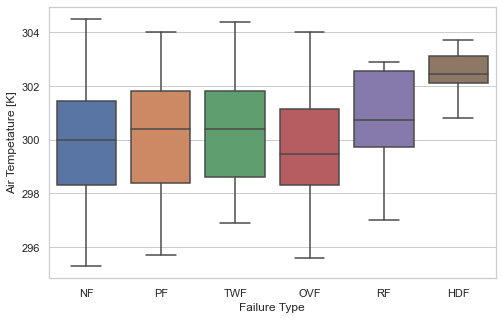

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x ='failure_type', y='air_temperature', data=df)
ax.set_xticklabels(['NF', 'PF', 'TWF', 'OVF', 'RF', 'HDF'], rotation= 0)
ax.set_xlabel('Failure Type')
ax.set_ylabel('Air Tempetature [K]')

Heat Dissipation Failure Occurs are likely occurs in high temperature

Text(0, 0.5, 'Process Tempetature [K]')

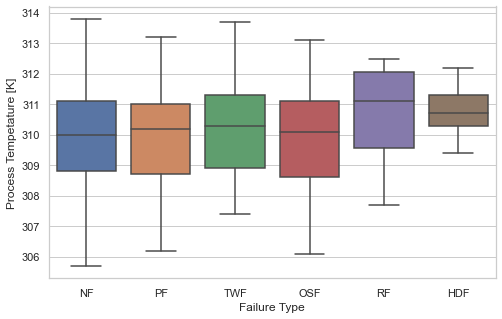

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x ='failure_type', y='process_temperature', data=df)
ax.set_xticklabels(['NF', 'PF', 'TWF', 'OSF', 'RF', 'HDF'], rotation= 0)
ax.set_xlabel('Failure Type')
ax.set_ylabel('Process Tempetature [K]')

Text(0, 0.5, 'Rotational Speed')

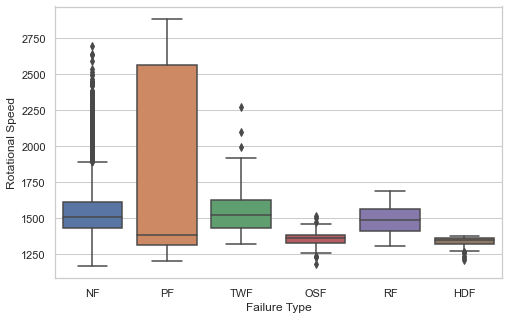

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x ='failure_type', y='rotational_speed', data=df)
ax.set_xticklabels(['NF', 'PF', 'TWF', 'OSF', 'RF', 'HDF'], rotation= 0)
ax.set_xlabel('Failure Type')
ax.set_ylabel('Rotational Speed')

we also can see that there are some outlier occurs in the rotational speed's columns. Specicifically
on the No Failure and Tool Wear Failure's column

In [15]:
outliers = []
def outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lower_bound = q1-(1.5*IQR)
    upper_bound = q3+(1.5*IQR)
    
    for i in data: 
        if (i<lower_bound or i>upper_bound):
            outliers.append(i)
    return outliers

sample_outliers = outliers_iqr(df['rotational_speed'])
print("Total outliers from Rotational Speed: ", len(sample_outliers))
print("% Outliers in Rotational Speed: {}".format(len(sample_outliers) / len(df['rotational_speed']) * 100))

Total outliers from Rotational Speed:  418
% Outliers in Rotational Speed: 4.18


Text(0, 0.5, 'Torque (Nm)')

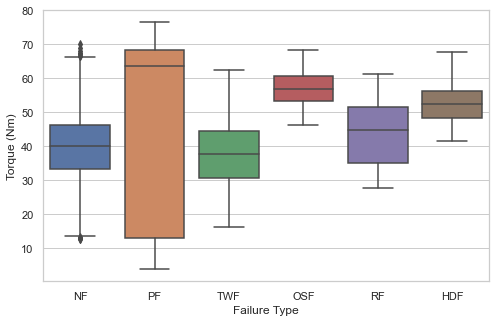

In [41]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x ='failure_type', y='torque', data=df)
ax.set_xticklabels(['NF', 'PF', 'TWF', 'OSF', 'RF', 'HDF'], rotation= 0)
ax.set_xlabel('Failure Type')
ax.set_ylabel('Torque (Nm)')

Text(0, 0.5, 'Tool Wear (Min)')

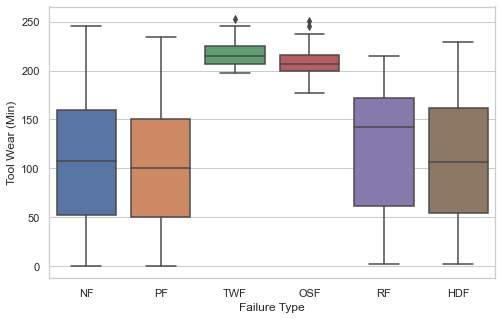

In [40]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.boxplot(x ='failure_type', y='tool_wear_min', data=df)
ax.set_xticklabels(['NF', 'PF', 'TWF', 'OSF', 'RF', 'HDF'], rotation= 0)
ax.set_xlabel('Failure Type')
ax.set_ylabel('Tool Wear (Min)')

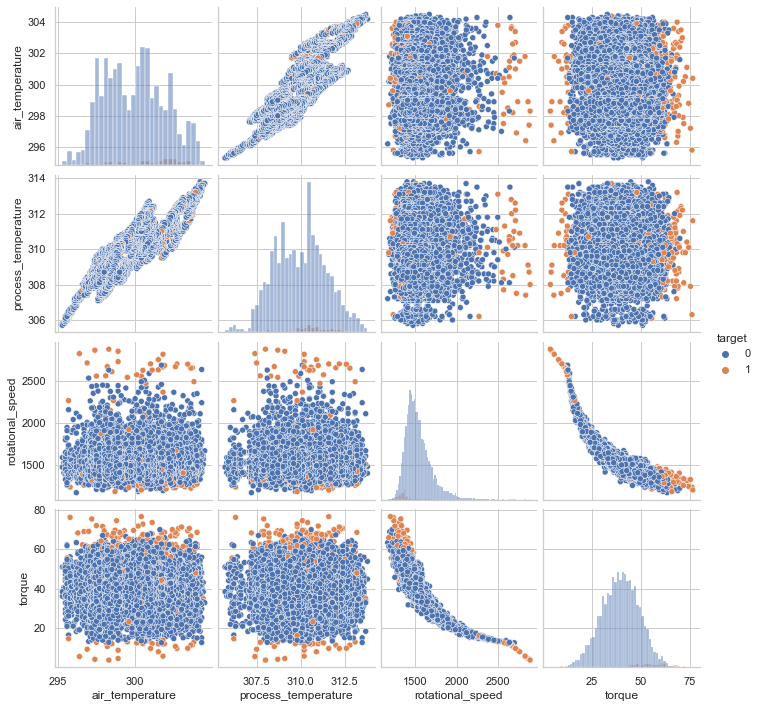

In [43]:
sns.pairplot(df[['air_temperature', 'process_temperature', 
                 'rotational_speed', 'torque', 'target']], hue='target', data=df, diag_kind= 'hist')

from the pair plot above we can see that the target feature, in this case the values 'Failure' or 'No Failure' are clearly separated each other

# Feature Engineering

As we know that the target feature's are highly imbalanced and it almost about 96.5 % of the target variabel were '0' or represent No Failures and only about 3.5 % were '1' or Failures. So we need to handling this situation to make the equal values. In this case we do undersampling to make target's feature have same shape each other.

In [62]:
df_failured = df[df['target'] == 1]
df_no_failure = df[df['target'] == 0]

df_no_failure_undersampled = resample(df_no_failure, 
                                    n_samples= 348,
                                    random_state= 42)
df_resample = pd.concat([df_no_failure_undersampled, df_failured])
df_resample.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
7568,L,300.2,311.0,1627.0,33.7,147.0,0,no_failure
881,L,295.7,306.2,1464.0,46.2,92.0,0,no_failure
5648,L,302.5,311.9,1401.0,44.9,203.0,0,no_failure
5439,L,303.0,312.5,1626.0,30.5,87.0,0,no_failure
5995,L,300.6,310.3,1920.0,22.3,223.0,0,no_failure


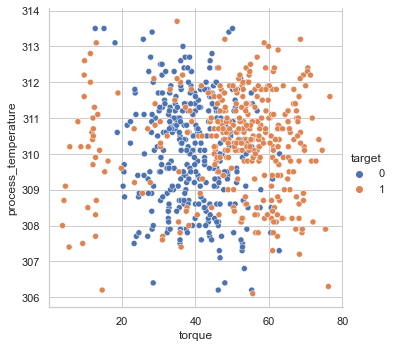

In [26]:
sns.relplot(data=df_resample, y='process_temperature', x='torque', kind='scatter', hue='target')

the scatterplot above showed the data after doing undersampling.it clearly showed that the data were highly separable each other

there were some columns that still with categorical type, thus it cannot be read to our machine learning model. so we need to convert the categorical column to the integer based column.

In [63]:
df_resample['type'] = df_resample['type'].astype('str')
df_resample['failure_type'] = df_resample['failure_type'].astype('str')

In [64]:
le = preprocessing.LabelEncoder()
df_resample['failure_type'] = le.fit_transform(df_resample['failure_type'])
df_resample['type'] = df_resample['type'].apply(lambda x: ['L', 'M', 'H'].index(x))

Splitting the data into two parts

I used the notation X (capital) to represent the column that we will use to make classification and y (lowercase) to represent the 
thing that we want to predict, in this case is whether or not the machine is failure on certain condition. in this case i also use
copy () method to ensure that the df_resample is not modified when we modify X or y, on the other words if we make a mistake when we
formatting the columns, I can just re-copy the df_resample rather than reload the original data 

in this case our dependent features or target features were the target columns and the independent features were air temperature, process temperature, rotational speed, torque and tool wear min

In [35]:
X = df_resample.drop(['target', 'failure_type'], axis= 1).copy()
y = df_resample['target'].copy()

since we know that the type's column were categorical type with no sequence. So we need to do one hot encoding (with dummies) to ensure that each type contribute equally. I also using drop first to the first dummies to avoid duplicated.
Then we ready to split the our data to train and test data. In this case we used 0.25 % (by default) of our data to be test data 

In [36]:
X_encoded = pd.get_dummies(X, columns=['type'], drop_first=True)
X_encoded.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,type_1,type_2
7568,300.2,311.0,1627.0,33.7,147.0,0,0
881,295.7,306.2,1464.0,46.2,92.0,0,0
5648,302.5,311.9,1401.0,44.9,203.0,0,0
5439,303.0,312.5,1626.0,30.5,87.0,0,0
5995,300.6,310.3,1920.0,22.3,223.0,0,0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state= 42, stratify=y)

# Feature Scaling

As we know that our data contains outliers in some features. so i decided to choose the robust scaler that were not 
sensitive to outliers and ensurig that all of the independent feature were contribute equally with same weight

In [38]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Modelling

Building the preliminary model

In [39]:
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

print('Test cv scores (SVC): {}'.format(clf_svm.score(X_test, y_test)))

clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

print('Test cv scores (Logistic Regression): {}'.format(clf_lr.score(X_test, y_test)))

Test cv scores (SVC): 0.7586206896551724
Test cv scores (Logistic Regression): 0.7528735632183908


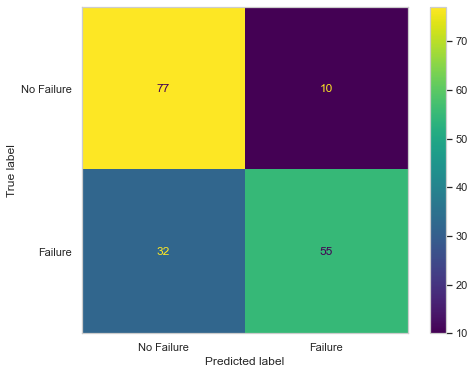

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

plot_confusion_matrix(clf_svm, X_test, y_test, 
                      ax=ax, display_labels = ['No Failure', 'Failure'])
plt.grid(b=None)

in the confusion matrix of our preliminary model of svm we can see that of the 87 machine that did No Failure, 77 (88.5 %) were correctly classified. And of the 87 that Failire, 55 (63%) were correctly predicted. it was not good because i think that the probability to predict
the Failure of the machine is more important compared to probability that we knowing the machine is not Failure. so we need to improve the probability to predict Failure machine using hyperparameter tuning to optimize the parameter

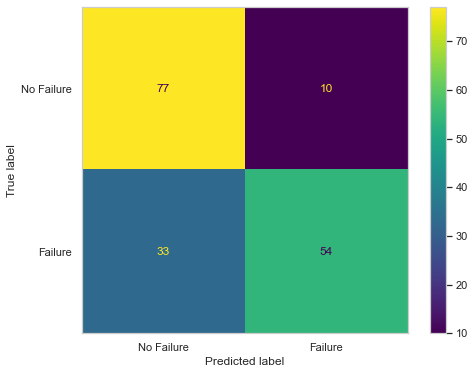

In [28]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(clf_lr, X_test, y_test, 
                      ax=ax, display_labels = ['No Failure', 'Failure'])
plt.grid(b=None)

in the confusion matrix of our preliminary model of logistic regression we can see that of the 87 machine that did No Failure, 77 (88.5 %) were correctly classified. And of the 87 that Failire, 54 (62%) were correctly predicted. same condition like our svm model, we need to improve the Failure's predictions using hyperparameter tuning to optimize the parameter

# Hyperparameter Tuning

In [29]:
param_grid = [{'gamma':['scale', 0.1, 1, 10, 50],
                'C': [0.1, 0.5, 1, 10],
                'kernel':['rbf', 'linear']}]

optimal_params = GridSearchCV(
                    SVC(),
                    param_grid,
                    cv= 5,
                    scoring='accuracy',
                    return_train_score=True)

optimal_params.fit(X_train, y_train)
y_pred = optimal_params.predict(X_test)


print('Best Params : {}'.format(optimal_params.best_params_))
print('Best CV Score : {}'.format(optimal_params.best_score_))
print('best score (Accuracy) : {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('best score (Precision) : {:.3f}'.format(precision_score(y_test, y_pred)))
print('best score (Recall) : {:.3f}'.format(recall_score(y_test, y_pred)))
print('best score (F1) : {:.3f}'.format(f1_score(y_test, y_pred,)))

Best Params : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score : 0.8964835164835165
best score (Accuracy) : 0.862
best score (Precision) : 0.880
best score (Recall) : 0.839
best score (F1) : 0.859


from the svm optimization, we can see that the ideal value of C or regularization is 10, the value of gamma is 'scale' and the kernel is 'rbf'

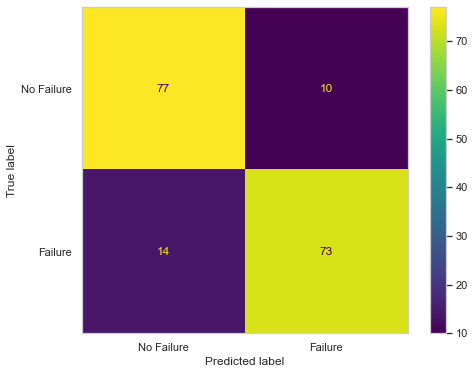

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(optimal_params, X_test, y_test, 
                      values_format='d', ax=ax,
                      display_labels = ['No Failure', 'Failure'])
plt.grid(b=None)

As the result of the confusion matrix of SVM after optimization are better than before, 18 failure machine's were correctly classified as
failure as the no failure's machine are does not improve. it was pretty good straight out of the box without much optimization

In [31]:
l1_space = np.linspace(0, 1, 30)
c_space = np.logspace(-5, 8, 15)

param_grid = [{'C':c_space,
              'penalty':['l1', 'l2'],
              'l1_ratio': l1_space}]

optimal_params_lr = GridSearchCV(
                    LogisticRegression(),
                    param_grid,
                    cv= 5,
                    scoring='accuracy',
                    return_train_score=True)

optimal_params_lr.fit(X_train, y_train)
y_pred = optimal_params_lr.predict(X_test)


print('Best Params : {}'.format(optimal_params_lr.best_params_))
print('Best CV Score : {}'.format(optimal_params.best_score_))
print('best score (Accuracy) : {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('best score (Precision) : {:.3f}'.format(precision_score(y_test, y_pred)))
print('best score (Recall) : {:.3f}'.format(recall_score(y_test, y_pred)))
print('best score (F1) : {:.3f}'.format(f1_score(y_test, y_pred,)))

Best Params : {'C': 0.4393970560760795, 'l1_ratio': 0.0, 'penalty': 'l2'}
Best CV Score : 0.8964835164835165
best score (Accuracy) : 0.764
best score (Precision) : 0.848
best score (Recall) : 0.644
best score (F1) : 0.732


from the Logistic Regression optimization, we can see that the ideal value of C is 0.43, l1_ratio is 0.0, and penalty is 'l2' 

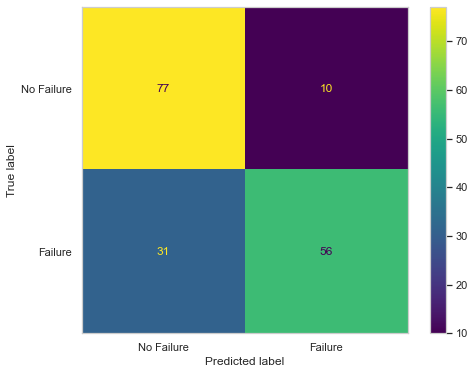

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(optimal_params_lr, X_test, y_test, 
                      values_format='d', ax=ax,
                      display_labels = ['No Failure', 'Failure'])
plt.grid(b=None)

As the result of the confusion matrix of Logistic Regression after optimization are better than before, 2 failure machine's were correctly classified as failure as the no failure's machine classified does not improve. it quite bad if we compared to the result from SVM optimization

# Final Model

In [40]:
clf_svm = SVC(kernel='rbf', C=10, gamma='scale')
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

print('Train Score (Accuracy): {:.3f}'.format(clf_svm.score(X_train, y_train)))
print('Test Score (Accuracy): {:.3f}'.format(clf_svm.score(X_test, y_test)))

Train Score (Accuracy): 0.939
Test Score (Accuracy): 0.862


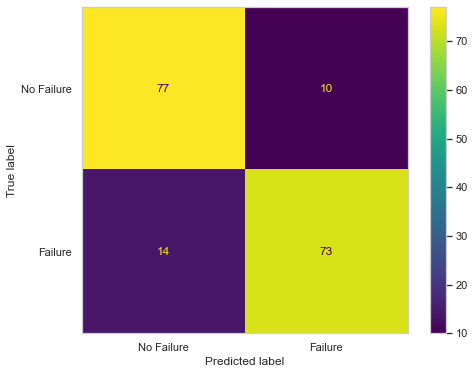

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(clf_svm, X_test, y_test, 
                      values_format='d', ax=ax,
                      display_labels = ['No Failure', 'Failure'])
plt.grid(b=None)

After comparing the result from two classification. In this case, we decided to use the SVM classification since that made the better prediction, with the 86.2 % accuracy score and it successfully predicted 73 out of 87 or about 84 % were correctly predict the machine that were failure and also succesfully predicted 77 out of 87 or about 88 % were correctly predicted the machine were not failure  

Later on our model's is ready to use to make a prediction about whether or not the machine will failure at certain condition. And we can do the maintenance to machine that we predicted to be failured  